In [2307]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from pymof import MOF

from sklearn.datasets import make_blobs
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors

from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cdist
from collections import defaultdict

import smote_variants as sv
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE

from collections import Counter
from sklearn.decomposition import PCA

In [2308]:
df_original = pd.read_csv(r'/Users/supakornsuksawat/Downloads/dataset for MSSG-SMOTE (clean&scaled)/Wilt dataset cleaned&scaled.csv')
data_name = 'Wilt'
df = df_original.copy()
# Select only numeric columns for normalization
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
scaler = MinMaxScaler()
label_encoder = LabelEncoder()

# Apply label encoding to each column that has non-numeric values
for column in df.columns:
    if df[column].dtype == 'object':  # Check if the column is non-numeric
        df[column] = label_encoder.fit_transform(df[column])

df = df.interpolate(axis=1) 

# Apply the scaler to the selected columns
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

col = df.columns.drop([df.columns[-1]])
target = df.columns[-1]

df_target = df[target]

X = df.iloc[:,:-1].to_numpy()
y = df[target].to_numpy()

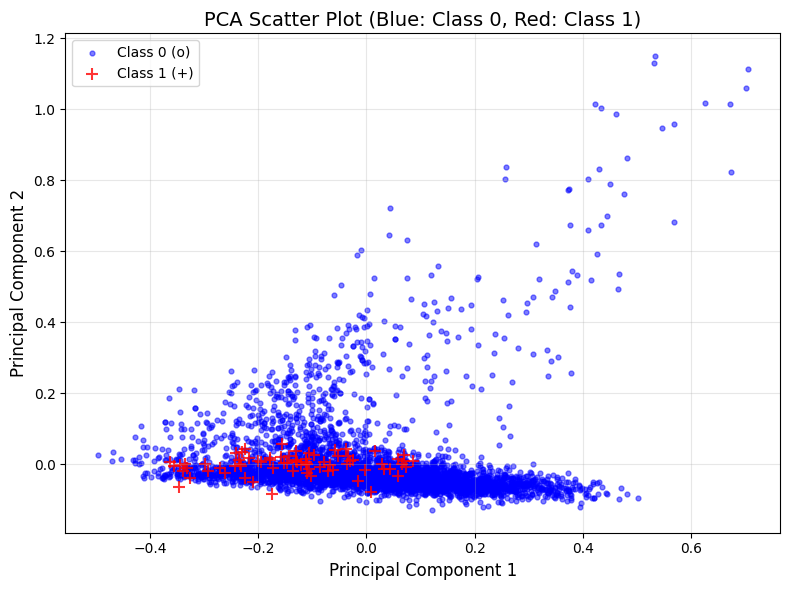

In [2309]:
# PCA transformation for subset (where y == 1)
pca = PCA(n_components=2)
X_subset = X  # Subset of features where y == 1
X_pca = pca.fit_transform(X_subset)

# Create subplot
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plot with different markers
ax.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], color='blue', alpha=0.5, marker='o', s=12, label="Class 0 (o)")
ax.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], color='red', alpha=0.8, marker='+', s=70, label="Class 1 (+)")

# Labels & Formatting
ax.set_title('PCA Scatter Plot (Blue: Class 0, Red: Class 1)', fontsize=14)
ax.set_xlabel('Principal Component 1', fontsize=12)
ax.set_ylabel('Principal Component 2', fontsize=12)
ax.grid(alpha=0.3)

# Legend
ax.legend()

# Show plot
plt.tight_layout()
plt.show()

In [2310]:
class MSSG :
    def __init__(self):
        pass

    def mof_scores(self, data):
        '''
        Function to calculate MOF scores from input Data
        '''
        model = MOF()
        model.fit(data)
        scores = model.decision_scores_
        return scores

    def add_class(self, data):
        '''
        Calculate quartile of MOF scores and add them as new columns  
        '''
        scores = self.mof_scores(data)
        quartiles = np.quantile(scores, [0.25, 0.5, 0.75])
        quartile_classes = np.digitize(scores, bins=quartiles, right=True) + 1 
        return quartile_classes
    
    def Directional(self , data , X_maj , X_min , all_sample):
        '''
        data        : instance in that we focus in this case 
        X_maj       : Majority instance features 
        X_min       : All of minority instance features 
        all_sample  : number of Synthetic instance --> number of Synthetic ins + data
        '''
        print(f'data : {len(data)}')

        #find majority NearestNeighbors instance from data
        nbrs = NearestNeighbors(n_neighbors=5).fit(X_maj) # we set n_neighbor = 5 because the maximum tainted value
        distances, indices = nbrs.kneighbors(data)

        num_sample = (all_sample)/len(data) #number of synthetic instance for each data instance 
        num_nearest_min = round(num_sample)
        
        print(f'num_nearest_min : {num_nearest_min}')
        print(f'n_samples_fit : {len(X_min)}')

        if num_nearest_min > len(X_min) :
            num_nearest_min = len(X_min)

        #find minority num_sample NearestNeighbors instance from data 
        #we want the number of NearestNeighbors = number the instance that we want to synthesize 
        nbrs_class1 = NearestNeighbors(n_neighbors = num_nearest_min ).fit(X_min) 
        distances_select , indices_select = nbrs_class1.kneighbors(data)
        
        #print(indices_select)

        synthetic_samples = []

        number_loop = round(all_sample / (len(data) + len(data)*num_nearest_min))
        
        if number_loop < 1 : 
            number_loop = 1
        print(f'number_loop : {number_loop}')
        for l in range(number_loop):
            for n in range(num_nearest_min) :
                for i, ins in enumerate(data):
                    #print(f'data[{i}] --> nearest[{n}]')
                    nearest_min_points = X_min[indices_select[i]]
                    nearest_min_ins = nearest_min_points[n] 

                    norm_diff = np.linalg.norm(nearest_min_ins - ins)

                    if norm_diff == 0:
                        alpha = 1
                    else:
                        ball_radius = distances[i][0] / norm_diff
                        alpha = np.random.uniform(0, ball_radius)  # Random proportion along the line  

                    synthetic_sample = ins + alpha * (nearest_min_ins - ins)
                    synthetic_samples.append(synthetic_sample)

        print(f'len(synthetic_samples : {len(synthetic_samples)}')
        return synthetic_samples
    
    def sample(self , X,y):
        X_min = X[y == 1] 
        y_min = y[y == 1]
        
        X_maj = X[y == 0]
        y_maj = y[y == 0]

        synthetic_sample = X_maj
        synthetic_target = y_maj

        quartile_all = self.add_class(X)
        quartile_minority = self.add_class(X_min)

        quartile_df = pd.DataFrame({
            'feature': X[y == 1].tolist(),
            'target': y[y == 1],
            'quartile_all': quartile_all[y == 1],
            'quartile_minority': quartile_minority
        })


        drop_df1 = quartile_df[(quartile_df['quartile_all'].isin([1,2]) & quartile_df['quartile_minority'].isin([1,2]))]
        quartile_df = quartile_df[~(quartile_df['quartile_all'].isin([1,2]) & quartile_df['quartile_minority'].isin([1,2]))]

        drop_df2 = quartile_df[(quartile_df['quartile_all'].isin([4]) & quartile_df['quartile_minority'].isin([4]))]
        quartile_df = quartile_df[~(quartile_df['quartile_all'].isin([4]) & quartile_df['quartile_minority'].isin([4]))]

        print('+++++++++++++++++++++++++++++++++++++++++')
        print(f'drop instance : {len(drop_df1) + len(drop_df2)}')

        synthetic_sample = np.vstack((synthetic_sample , np.array(drop_df1['feature'].tolist())))
        synthetic_target = np.hstack((synthetic_target , np.array(drop_df1['target'].tolist())))

        synthetic_sample = np.vstack((synthetic_sample , np.array(drop_df2['feature'].tolist())))
        synthetic_target = np.hstack((synthetic_target , np.array(drop_df2['target'].tolist())))

        print(f'len(synthetic array) : {len(synthetic_sample)}')
        print(f'remaining synthetic instance : {(len(X[y==0])*2) - len(synthetic_sample)}')
        print('+++++++++++++++++++++++++++++++++++++++++')

        #?==================================================================================
        X_d = len(drop_df1) + len(drop_df2)
        X_expec = len(X) - (X_d)
        print(f'X_expec : {X_expec}')
        
        r = (len(X_min)) / (len(X))
        final_synthesize = round(((1-r)) * (len(X)))
        final_synthesize = final_synthesize - X_d
        number_synthesize = final_synthesize/9
        
        print(f'X = {len(X)} , X_maj = {len(X_maj)} , X_min = {len(X_min)}')
        print(f'r = {r} and x = {number_synthesize} | ({number_synthesize *9}) where X - X_min = {(len(X) - len(X_min))}')
        #?==================================================================================

        combinations = quartile_df[['quartile_minority' , 'quartile_all']].values.tolist()
        combination_counts = dict(Counter(map(tuple, combinations)))

        filtered_combinations = {key: value for key, value in combination_counts.items()}
        print(len(filtered_combinations))
        print(filtered_combinations)

        print(f'number that expectation majority = {len(X_maj)} minority = {len(X_min)} : {len(X_maj) - len(X_min)}')
        print(f'number of synthetic instance : {(len(X_maj) - len(X_min))/len(filtered_combinations)}')

        ratio_list = [number_synthesize , number_synthesize , 4*number_synthesize , 3*number_synthesize]
        print(f'Ratio : {ratio_list}')

        for combi in filtered_combinations : 
            if combi[0] < combi[1] :
                select_df = quartile_df[(quartile_df['quartile_minority'] == combi[0]) & (quartile_df['quartile_all'] == combi[1])]
                
                ratio_syn = ratio_list[combi[0] - 1] * (len(select_df) / len(quartile_df[quartile_df['quartile_minority'].isin([combi[0]])]))
                print(f'ratio syn in case [{combi}] : {ratio_syn}')

                synthetic = []
                select_df = select_df.drop_duplicates(subset=['feature'])
                select_df_feature = np.array(select_df['feature'].tolist())

                new_sample = self.Directional(select_df_feature, X_maj , X_min , round(ratio_syn) )
                print(f'synthetic instance = {len(new_sample)}')

                synthetic.append(new_sample)

                if len(synthetic[0]) == 0 : 
                    continue
                else :
                    synthetic_array = np.vstack(synthetic)
                    synthetic_sample = np.vstack((synthetic_sample , synthetic_array))
                    synthetic_target = np.hstack((synthetic_target , [1]*len(synthetic_array)))   
                    print(f'len(synthetic array) : {len(synthetic_sample)}')            

            else : 
                select_df = quartile_df[(quartile_df['quartile_minority'] == combi[0]) & (quartile_df['quartile_all'] == combi[1] )]

                ratio_syn = ratio_list[combi[0] - 1] * (len(select_df) / len(quartile_df[quartile_df['quartile_minority'].isin([combi[0]])]))
                print(f'ratio syn in case [{combi}] : {ratio_syn}')

                # when number of instance <= 1 skip this case 
                if len(select_df) <= 1 : 
                    continue

                # if number of instance < 6 can't use SMOTE with parameter Neighbors = 5 but we can use DSS method
                elif len(select_df) <= 10 :
                    select_df = quartile_df[(quartile_df['quartile_minority'] == combi[0]) & (quartile_df['quartile_all'] == combi[1] )]
                    synthetic = []
                    select_df = select_df.drop_duplicates(subset=['feature'])
                    select_df_feature = np.array(select_df['feature'].tolist())

                    new_sample = self.Directional(select_df_feature, X_maj , X_min , round(ratio_syn))
                    print(f'synthetic instance = {len(new_sample)}')
                    synthetic.append(new_sample)
                    if len(synthetic[0]) == 0 : 
                        continue
                    else :
                        synthetic_array = np.vstack(synthetic)
                        synthetic_sample = np.vstack((synthetic_sample , synthetic_array))
                        synthetic_target = np.hstack((synthetic_target , [1]*len(synthetic_array)))   
                        print(f'len(synthetic array) : {len(synthetic_sample)}')     

                else :
                    ratio_SMOTE = ((ratio_syn)) / len(X_maj)
                    
                    print(ratio_SMOTE)

                    select_df_feature = np.vstack((X_maj,np.array(select_df['feature'].tolist())))
                    select_df_target = np.hstack((y_maj ,np.array(select_df['target'].tolist())))
                    smote = SMOTE(sampling_strategy= ratio_SMOTE ,random_state=42)
                    X_border , y_border = smote.fit_resample(select_df_feature,select_df_target)
                    print(f'synthetic instance | SMOTE = {len(X_border[y_border == 1])}')
                    synthetic_sample = np.vstack((synthetic_sample , X_border[y_border == 1]))
                    synthetic_target = np.hstack((synthetic_target , y_border[y_border == 1]))
                    print(f'len(synthetic array) : {len(synthetic_sample)}')
            
        return synthetic_sample , synthetic_target

In [2311]:
X = df.iloc[:,:-1].to_numpy()
y = df[target].to_numpy()

synthetic_sample , synthetic_target = MSSG().sample(X,y)
print(f'number of synthetic instance     : {len(synthetic_sample)}')
print('number that we want to synthesis :' ,len(X[y==0])*2)

+++++++++++++++++++++++++++++++++++++++++
drop instance : 30
len(synthetic array) : 4295
remaining synthetic instance : 4235
+++++++++++++++++++++++++++++++++++++++++
X_expec : 4309
X = 4339 , X_maj = 4265 , X_min = 74
r = 0.017054620880387186 and x = 470.55555555555554 | (4235.0) where X - X_min = 4265
8
{(1, 3): 7, (2, 3): 10, (3, 2): 5, (4, 3): 7, (3, 3): 7, (3, 1): 1, (4, 2): 2, (3, 4): 5}
number that expectation majority = 4265 minority = 74 : 4191
number of synthetic instance : 523.875
Ratio : [470.55555555555554, 470.55555555555554, 1882.2222222222222, 1411.6666666666665]
ratio syn in case [(1, 3)] : 470.55555555555554
data : 7
num_nearest_min : 67
n_samples_fit : 74
number_loop : 1
len(synthetic_samples : 469
synthetic instance = 469
len(synthetic array) : 4764
ratio syn in case [(2, 3)] : 470.55555555555554
data : 10
num_nearest_min : 47
n_samples_fit : 74
number_loop : 1
len(synthetic_samples : 470
synthetic instance = 470
len(synthetic array) : 5234
ratio syn in case [(3, 2)

In [2312]:
# Apply Borderline-SMOTE using smote-variants
import smote_variants as sv
smote = sv.SMOTE()

X_resampled, y_resampled = smote.sample(X, y)

# Apply Borderline-SMOTE using smote-variants
borderline_smote = BorderlineSMOTE(kind='borderline-1', random_state=42)
X_Borderline, y_Borderline = borderline_smote.fit_resample(X, y)

import smote_variants as sv
# Apply a SMOTE variant from smote-variants library
smote_variant = sv.Safe_Level_SMOTE()
X_res, y_res = smote_variant.sample(X, y)

2025-02-25 22:09:56,183:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")
2025-02-25 22:09:56,196:INFO:Safe_Level_SMOTE: Running sampling via ('Safe_Level_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


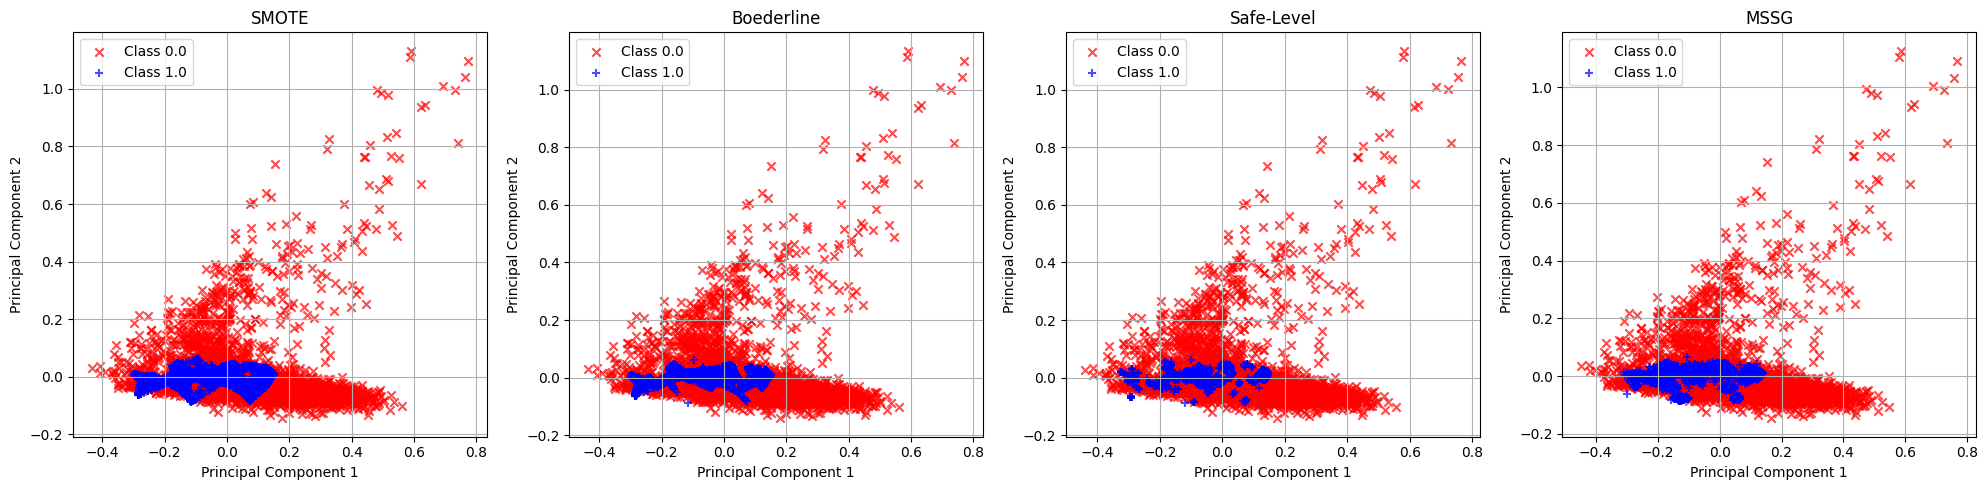

In [2313]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Function to plot multiple datasets with PCA
def plot_multiple_datasets(datasets, labels, targets):
    num_datasets = len(datasets)
    fig, axes = plt.subplots(1, num_datasets, figsize=(5 * num_datasets, 5))
    colors = ['red', 'blue']  # Colors for the two classes
    markers = ['x', '+']      # Marker style for the two classes

    for i, (X, y, label) in enumerate(zip(datasets, targets, labels)):
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)

        ax = axes[i] if num_datasets > 1 else axes
        for idx, class_label in enumerate(np.unique(y)):
            ax.scatter(
                X_pca[y == class_label, 0], 
                X_pca[y == class_label, 1], 
                color=colors[idx],
                marker=markers[idx],
                label=f"Class {class_label}",
                alpha=0.7
            )
        ax.set_title(label)
        ax.set_xlabel("Principal Component 1")
        ax.set_ylabel("Principal Component 2")
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# Example usage
# Create example data (replace with your actual datasets and targets)
datasets = [
    X_resampled,  # Dataset 1
    X_Borderline,  # Dataset 2
    X_res,   # Dataset 3
    synthetic_sample    # Dataset 4
]
targets = [
    y_resampled,  # Binary classes for Dataset 1
    y_Borderline,  # Binary classes for Dataset 2
    y_res,   # Binary classes for Dataset 3
    synthetic_target    # Binary classes for Dataset 4
]
labels = ["SMOTE", "Boederline", "Safe-Level", "MSSG"]

# Plot the datasets
plot_multiple_datasets(datasets, labels, targets)


In [2314]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


def K_fold(classification , X , y , smote_technique ):

	
	kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

	report_kfold = []
	Precision = []
	Recall = []
	F1 = []

	for fold , (train_ix, test_ix) in enumerate(kfold.split(X, y), 1):
		# select rows
		train_X, test_X = X[train_ix], X[test_ix]
		train_y, test_y = y[train_ix], y[test_ix]
		# summarize train and test composition
		train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
		test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])

		
		# Apply Borderline-SMOTE using smote-variants
		if smote_technique == 'Original' : 
			X_train_resampled, y_train_resampled = train_X, train_y

		else :
			smote = smote_technique
			
			X_train_resampled, y_train_resampled = smote(train_X, train_y)

		model = classification

		model.fit(X_train_resampled, y_train_resampled)
		
		# Predictions
		y_pred = model.predict(test_X)

		report = classification_report(test_y, y_pred)
		
		# Calculate metrics
		Precision.append(precision_score(test_y, y_pred))
		Recall.append(recall_score(test_y, y_pred))
		F1.append(f1_score(test_y, y_pred))

	# Calculate mean of metrics
	mean_precision = np.mean(Precision)
	mean_recall = np.mean(Recall)
	mean_f1 = np.mean(F1)

	return mean_precision , mean_recall , mean_f1 



classifiers = {
    '(1)kNN': KNeighborsClassifier(n_neighbors=7 , p=2),
    '(2)Decision Tree': DecisionTreeClassifier(),
    '(3)Neural Network': MLPClassifier(hidden_layer_sizes=(16,16,2)  ,max_iter=2000 , activation= 'tanh'),
    '(4)SVM': SVC(kernel='rbf', gamma='scale'),
    '(5)Random Forest': RandomForestClassifier()
}

techniques = {
    '(1)Original': 'Original',
    '(2)SMOTE': sv.SMOTE().sample,
    '(3)Borderline':  BorderlineSMOTE(kind='borderline-1', random_state=42).fit_resample ,
    '(4)Safe-level': sv.Safe_Level_SMOTE().sample,
    '(5)MSSG': MSSG().sample,
}
kfold_result = []

for technique_name, smote in techniques.items():
    for clf_name, clf in classifiers.items():
        mean_precision , mean_recall , mean_f1 = K_fold( clf , X , y , smote)
        kfold_result.append({
            'Data Set' : data_name,
            'Class': 1,
            'Technique': technique_name,
            'Classifier' : clf_name ,
            'Precision' : mean_precision,
            'Recall' : mean_recall,
            'F1-score' : mean_f1,
        })

kfold_result_table = pd.DataFrame(kfold_result)

# Pivot the table to have techniques as columns, and the other metrics as rows
kfold_result_pivot = kfold_result_table.pivot_table(
    index=['Classifier', 'Class' , 'Data Set'],
    columns='Technique',
    values=['Precision', 'Recall', 'F1-score']
)

kfold_result_pivot.columns = ['_'.join(col).strip() for col in kfold_result_pivot.columns.values]
kfold_result_pivot.reset_index(inplace=True)

/Users/supakornsuksawat/Documents/Python Project Folder/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/supakornsuksawat/Documents/Python Project Folder/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/supakornsuksawat/Documents/Python Project Folder/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

+++++++++++++++++++++++++++++++++++++++++
drop instance : 19
len(synthetic array) : 3431
remaining synthetic instance : 3393
+++++++++++++++++++++++++++++++++++++++++
X_expec : 3452
X = 3471 , X_maj = 3412 , X_min = 59
r = 0.01699798329011812 and x = 377.0 | (3393.0) where X - X_min = 3412
9
{(1, 3): 5, (4, 3): 10, (3, 3): 3, (3, 1): 2, (2, 3): 9, (3, 4): 5, (3, 2): 4, (2, 4): 1, (4, 2): 1}
number that expectation majority = 3412 minority = 59 : 3353
number of synthetic instance : 372.55555555555554
Ratio : [377.0, 377.0, 1508.0, 1131.0]
ratio syn in case [(1, 3)] : 377.0
data : 5
num_nearest_min : 75
n_samples_fit : 59
number_loop : 1
len(synthetic_samples : 295
synthetic instance = 295
len(synthetic array) : 3726
ratio syn in case [(4, 3)] : 1028.1818181818182
data : 10
num_nearest_min : 103
n_samples_fit : 59
number_loop : 2
len(synthetic_samples : 1180
synthetic instance = 1180
len(synthetic array) : 4906
ratio syn in case [(3, 3)] : 323.1428571428571
data : 3
num_nearest_min : 108

In [2315]:
kfold_result_pivot

,Classifier,Class,Data Set,F1-score_(1)Original,F1-score_(2)SMOTE,F1-score_(3)Borderline,F1-score_(4)Safe-level,F1-score_(5)MSSG,Precision_(1)Original,Precision_(2)SMOTE,Precision_(3)Borderline,Precision_(4)Safe-level,Precision_(5)MSSG,Recall_(1)Original,Recall_(2)SMOTE,Recall_(3)Borderline,Recall_(4)Safe-level,Recall_(5)MSSG
0,(1)kNN,1,Wilt,0.335191,0.504616,0.539550,0.376717,0.527304,1.000000,0.377273,0.437701,0.281275,0.416283,0.202857,0.785714,0.718095,0.597143,0.730476
1,(2)Decision Tree,1,Wilt,0.761785,0.735106,0.716935,0.551513,0.722408,0.784713,0.679148,0.674673,0.460333,0.663258,0.757143,0.809524,0.783810,0.689524,0.810476
2,(3)Neural Network,1,Wilt,0.000000,0.758979,0.791850,0.583163,0.730578,0.000000,0.663101,0.682141,0.423897,0.617842,0.000000,0.945714,0.960000,0.972381,0.959048
3,(4)SVM,1,Wilt,0.000000,0.560695,0.647242,0.566877,0.582945,0.000000,0.398685,0.490169,0.402926,0.431967,0.000000,0.986667,0.986667,0.986667,0.986667
4,(5)Random Forest,1,Wilt,0.728497,0.832884,0.784423,0.740092,0.814223,0.961111,0.851588,0.837358,0.825674,0.854385,0.594286,0.823810,0.743810,0.676190,0.796190


In [2316]:
f1_columns = [col for col in kfold_result_pivot.columns if 'F1-score_' in col]
Precision_columns = [col for col in kfold_result_pivot.columns if 'Precision_' in col]
Recall_columns = [col for col in kfold_result_pivot.columns if 'Recall_' in col]

In [2317]:
f1_result = kfold_result_pivot.iloc[:,0:8]
f1_result["Max_F1_score"] = f1_result[f1_columns].idxmax(axis=1)
f1_result

,Classifier,Class,Data Set,F1-score_(1)Original,F1-score_(2)SMOTE,F1-score_(3)Borderline,F1-score_(4)Safe-level,F1-score_(5)MSSG,Max_F1_score
0,(1)kNN,1,Wilt,0.335191,0.504616,0.539550,0.376717,0.527304,F1-score_(3)Borderline
1,(2)Decision Tree,1,Wilt,0.761785,0.735106,0.716935,0.551513,0.722408,F1-score_(1)Original
2,(3)Neural Network,1,Wilt,0.000000,0.758979,0.791850,0.583163,0.730578,F1-score_(3)Borderline
3,(4)SVM,1,Wilt,0.000000,0.560695,0.647242,0.566877,0.582945,F1-score_(3)Borderline
4,(5)Random Forest,1,Wilt,0.728497,0.832884,0.784423,0.740092,0.814223,F1-score_(2)SMOTE


## Ranking F1-Scores 

In [2318]:
# Create a DataFrame to store rankings
rankings_F1_df = f1_result[['Classifier','Data Set']].copy()

# Add ranked F1-scores to the new DataFrame
for col in f1_columns:
    rankings_F1_df[col] = f1_result[f1_columns].rank(axis=1, ascending=False)[col]

# Convert ranks to integers for better readability
rankings_F1_df[f1_columns] = rankings_F1_df[f1_columns].astype(int)

# Calculate the average ranking for each F1-score column
average_ranking = rankings_F1_df[f1_columns].mean().to_dict()

# Display the new DataFrame
rankings_F1_df

,Classifier,Data Set,F1-score_(1)Original,F1-score_(2)SMOTE,F1-score_(3)Borderline,F1-score_(4)Safe-level,F1-score_(5)MSSG
0,(1)kNN,Wilt,5,3,1,4,2
1,(2)Decision Tree,Wilt,1,2,4,5,3
2,(3)Neural Network,Wilt,5,2,1,4,3
3,(4)SVM,Wilt,5,4,1,3,2
4,(5)Random Forest,Wilt,5,1,3,4,2


## Ranking Precision

In [2319]:
# Create a DataFrame to store rankings
rankings_Precision_df = kfold_result_pivot[['Classifier','Data Set']].copy()

# Add ranked F1-scores to the new DataFrame
for col in Precision_columns:
    rankings_Precision_df[col] = kfold_result_pivot[Precision_columns].rank(axis=1, ascending=False)[col]

# Convert ranks to integers for better readability
rankings_Precision_df[Precision_columns] = rankings_Precision_df[Precision_columns].astype(int)

# Display the new DataFrame
rankings_Precision_df


,Classifier,Data Set,Precision_(1)Original,Precision_(2)SMOTE,Precision_(3)Borderline,Precision_(4)Safe-level,Precision_(5)MSSG
0,(1)kNN,Wilt,1,4,2,5,3
1,(2)Decision Tree,Wilt,1,2,3,5,4
2,(3)Neural Network,Wilt,5,2,1,4,3
3,(4)SVM,Wilt,5,4,1,3,2
4,(5)Random Forest,Wilt,1,3,4,5,2


## Ranking Recall

In [2320]:
# Create a DataFrame to store rankings
rankings_Recall_df = kfold_result_pivot[['Classifier','Data Set']].copy()

# Add ranked F1-scores to the new DataFrame
for col in Recall_columns:
    rankings_Recall_df[col] = kfold_result_pivot[Recall_columns].rank(axis=1, ascending=False)[col]

# Convert ranks to integers for better readability
rankings_Recall_df[Recall_columns] = rankings_Recall_df[Recall_columns].astype(int)

# Display the new DataFrame
rankings_Recall_df

,Classifier,Data Set,Recall_(1)Original,Recall_(2)SMOTE,Recall_(3)Borderline,Recall_(4)Safe-level,Recall_(5)MSSG
0,(1)kNN,Wilt,5,1,3,4,2
1,(2)Decision Tree,Wilt,4,2,3,5,1
2,(3)Neural Network,Wilt,5,4,2,1,3
3,(4)SVM,Wilt,5,2,2,2,2
4,(5)Random Forest,Wilt,5,1,3,4,2


In [2321]:
average_ranking

{'F1-score_(1)Original': 4.2,
 'F1-score_(2)SMOTE': 2.4,
 'F1-score_(3)Borderline': 2.0,
 'F1-score_(4)Safe-level': 4.0,
 'F1-score_(5)MSSG': 2.4}

In [2322]:
f1_result["F1-score_(5)MSSG"].mean()

np.float64(0.6754917351058041)

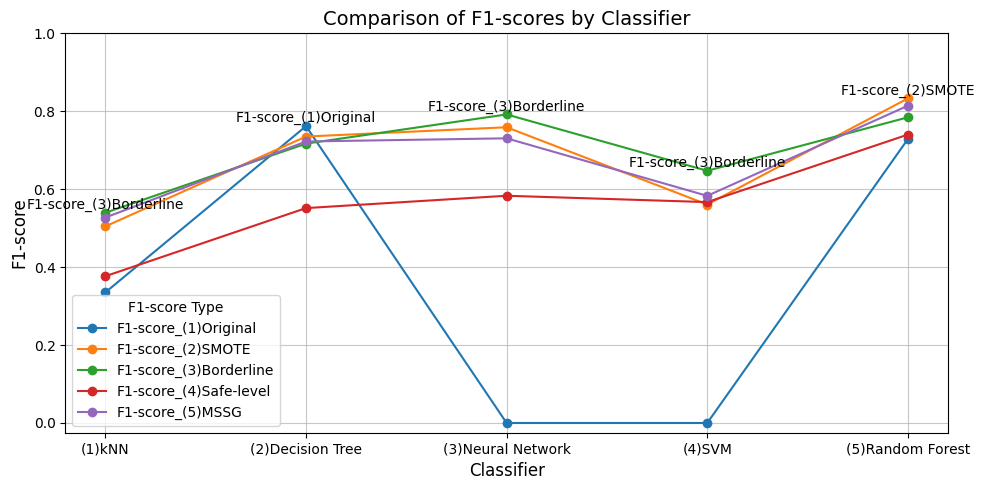

In [2323]:
f1_columns = [
    "F1-score_(1)Original",
    "F1-score_(2)SMOTE",
    "F1-score_(3)Borderline",
    "F1-score_(4)Safe-level",
    "F1-score_(5)MSSG",
]

plt.figure(figsize=(10, 5))

for col in f1_columns:
    plt.plot(f1_result["Classifier"], f1_result[col], marker='o', label=col)

for i in range(len(f1_result)):
    max_col = f1_result["Max_F1_score"].iloc[i]
    max_value = f1_result[max_col].iloc[i]
    classifier = f1_result["Classifier"].iloc[i]
    plt.text(classifier, max_value + 0.01, max_col, fontsize=10, ha='center')

plt.xlabel("Classifier", fontsize=12)
plt.ylabel("F1-score", fontsize=12)
plt.title("Comparison of F1-scores by Classifier", fontsize=14)
plt.xticks(rotation=0, fontsize=10)
plt.legend(title="F1-score Type", fontsize=10)
plt.ylim(f1_result[f1_columns].min(axis=1).min() - 0.025 ,1)

plt.grid( linestyle="-", alpha=0.7)

plt.tight_layout()
plt.show()

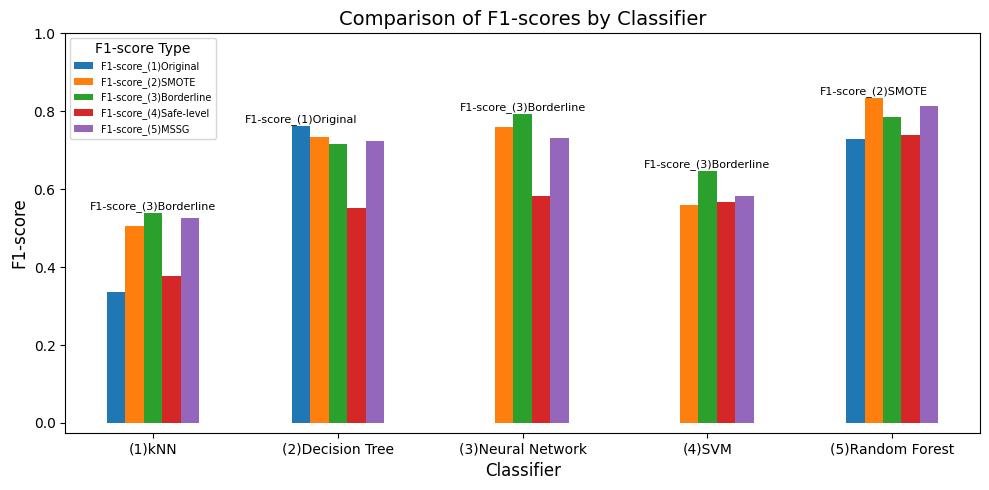

In [2324]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Number of classifiers and number of F1-score methods
n_classifiers = len(f1_result)
n_methods = len(f1_columns)

# X-axis positions for classifiers
x = np.arange(n_classifiers)

# Bar width (adjust for spacing)
bar_width = 0.1

# Loop through each F1-score column and plot bars
for i, col in enumerate(f1_columns):
    plt.bar(x + i * bar_width, f1_result[col], width=bar_width, label=col)

# Annotate max F1-score for each classifier
for i in range(n_classifiers):
    max_col = f1_result["Max_F1_score"].iloc[i]
    max_value = f1_result[max_col].iloc[i]
    plt.text(x[i] + (f1_columns.index(max_col) * bar_width), max_value + 0.01, 
             max_col, fontsize=8, ha='center')

# X-axis labels
plt.xticks(x + (n_methods / 2 - 0.5) * bar_width, f1_result["Classifier"], fontsize=10)

# Labels and title
plt.xlabel("Classifier", fontsize=12)
plt.ylabel("F1-score", fontsize=12)
plt.title("Comparison of F1-scores by Classifier", fontsize=14)

# Legend
plt.legend(title="F1-score Type", fontsize=7)

# Grid and formatting
plt.ylim(f1_result[f1_columns].min().min() - 0.025, 1)

#plt.grid(axis='y', linestyle="-", alpha=0.5)

plt.tight_layout()
plt.show()


In [2325]:
kfold_result_pivot.to_excel(r'/Users/supakornsuksawat/Documents/MSSG_SMOTE_TEST/Kfold_class_mark9/kfold_result_' + data_name + '.xlsx', index=False)